In [2]:
"""ZAIMPORTOWANIE ODPOWIEDNICH BIBLIOTEK"""
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

In [3]:
"""WSTĘPNE USTAWIENIA PRZED WCZYTANIEM SYGNAŁU"""

d_path = "eeg_files/20241017_kp.bdf" #ścieżka do pliku
ch_eog = ["EXG1","EXG2"] #zdefiniowanie dedykowanych kanałów EOG
ch_ecg = ["EXG3","EXG4"] #zdefiniowanie dedykowanych kanałów ECG
ch_exclude = [f"EXG{i}" for i in range(5,9)] #wykluczenie kanałów niewykorzystanych w badaniu

In [6]:
"""ZAŁADOWANIE SYGNAŁU I USTAWIENIE UKŁADU ELEKTROD"""
raw = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw.set_montage("biosemi64") #ustawienie montazu biosemi


Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [7]:
"""NAŁOŻENIE FILTRU ZAPOROWOPRZEPUSTOWEGO - FILTRACJA SZUMU SIECIOWEGO"""
notch = 50 #zdefiniowanie częstotliwości filtra
raw.notch_filter(notch)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

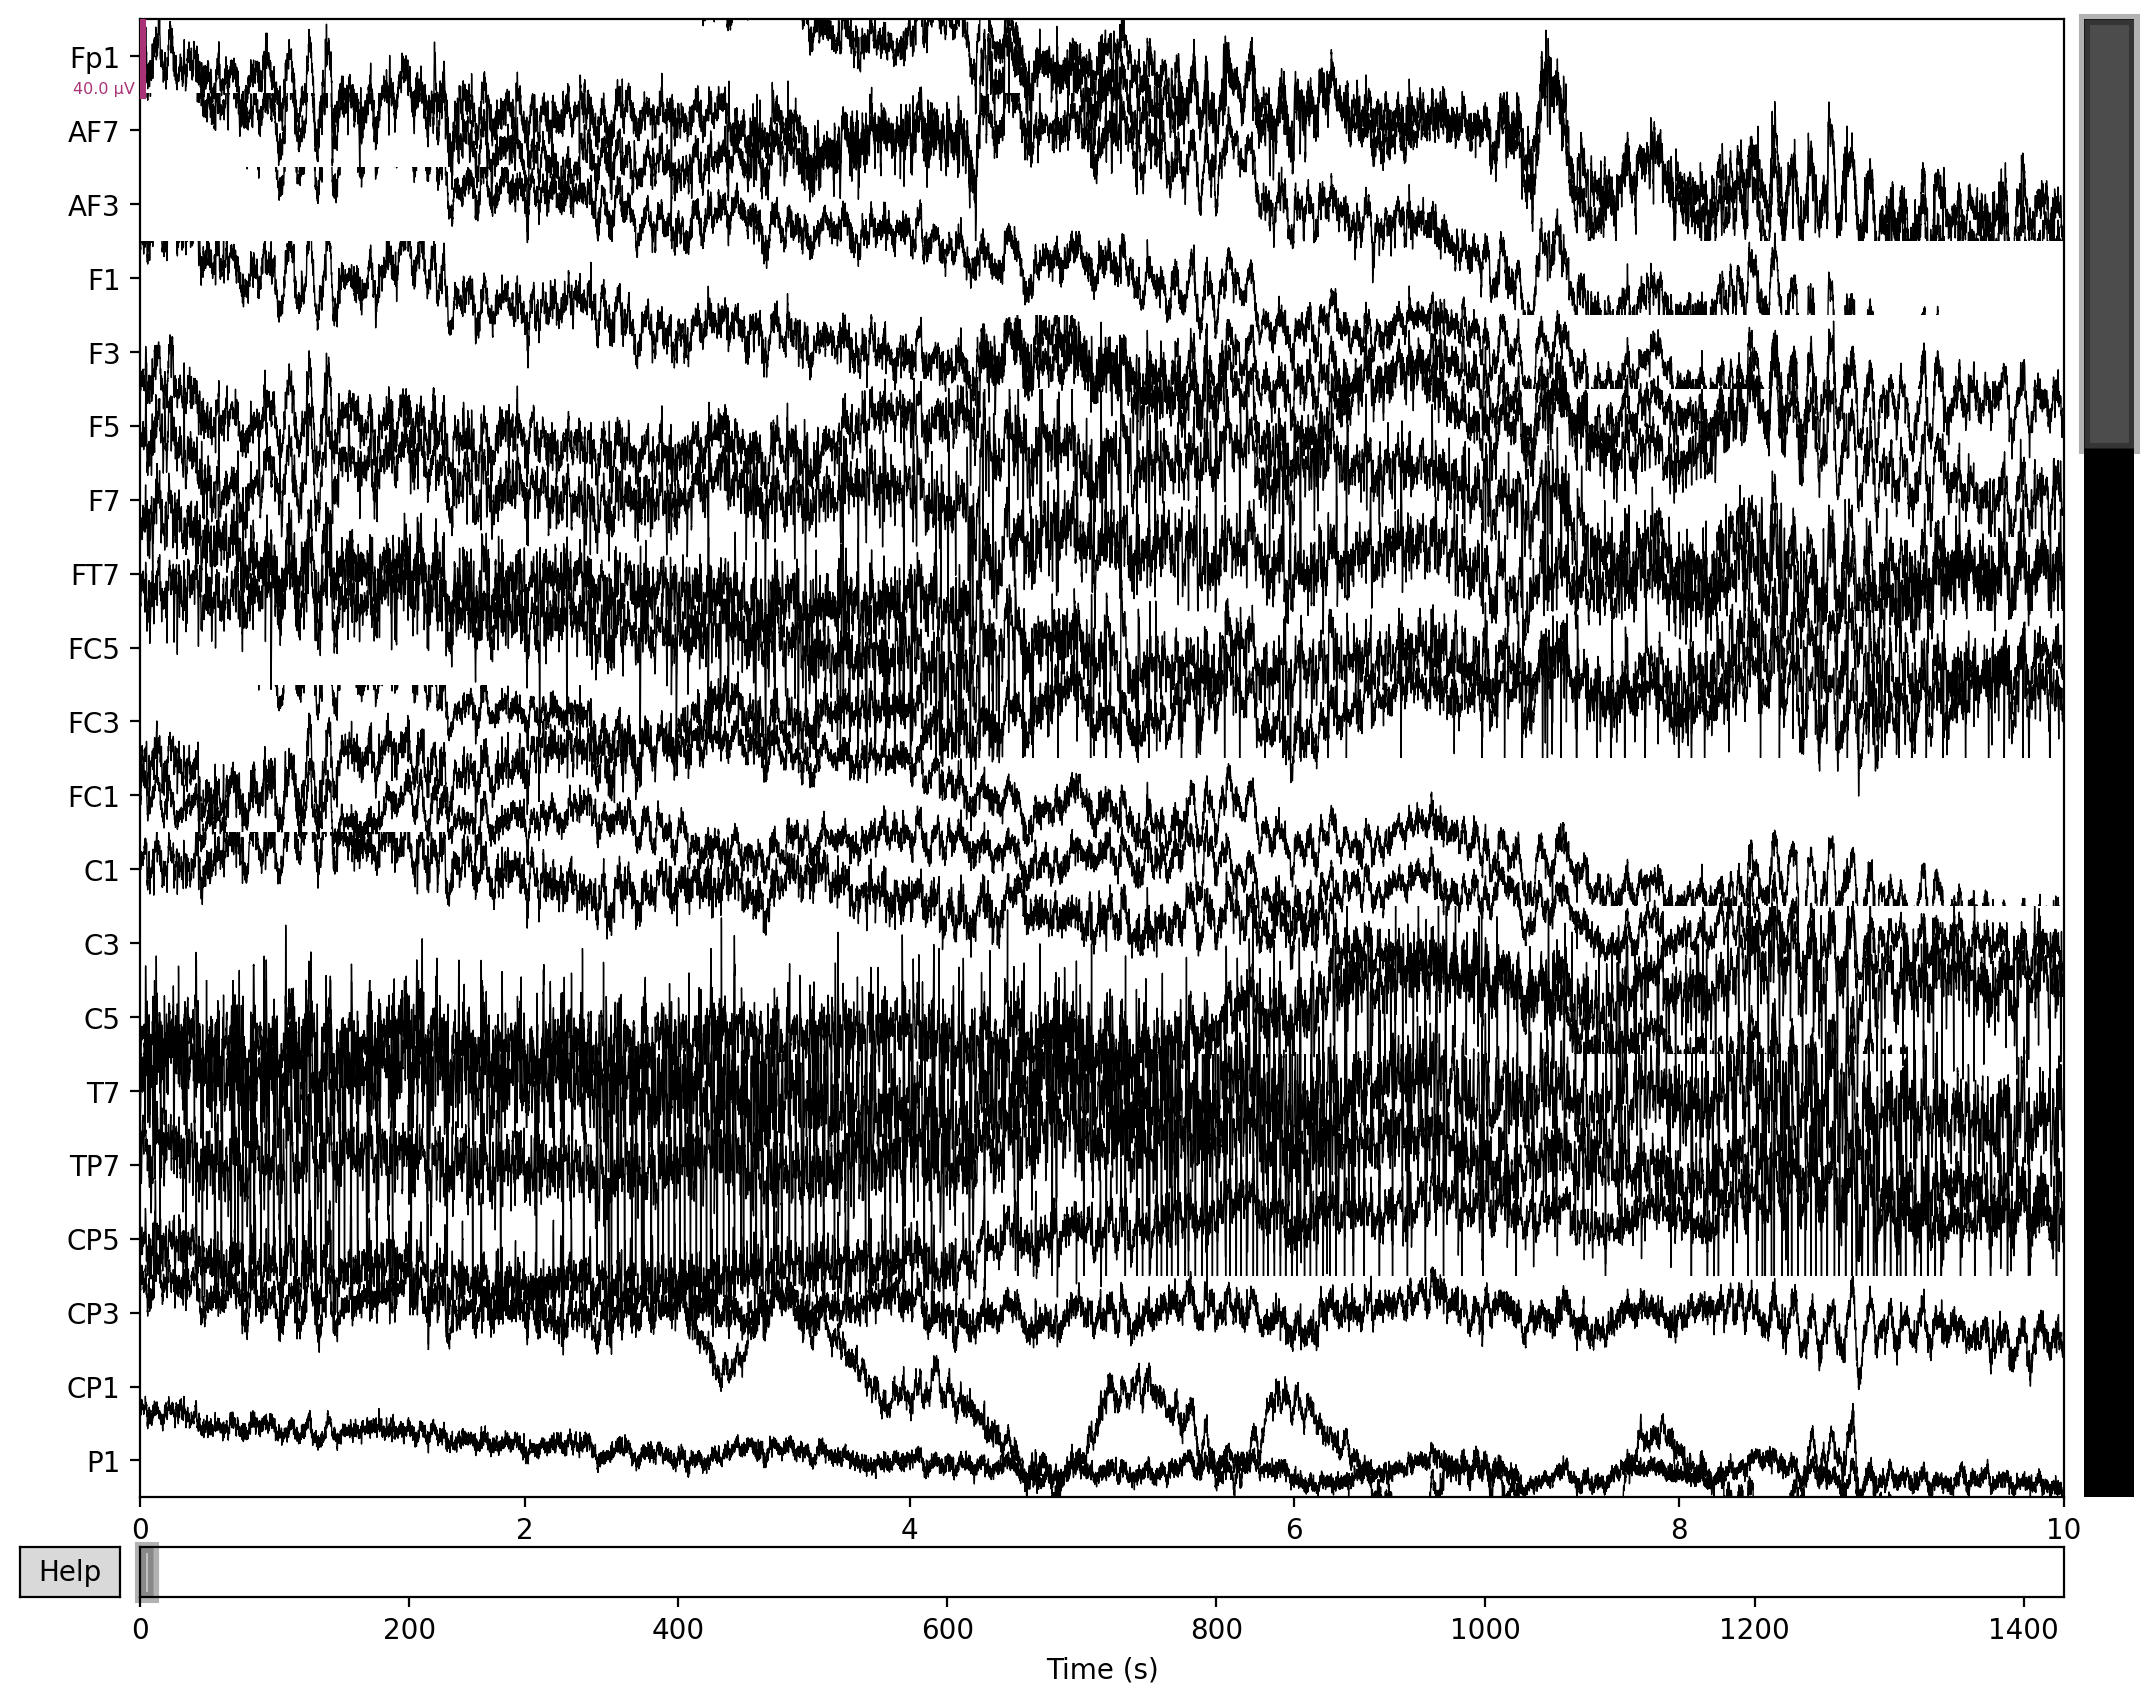

In [16]:
"""WIZUALIZACJA SYGNAŁU"""
raw.plot() 

In [18]:
pip install pyprep

  Using cached pyprep-0.4.3-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached pyprep-0.4.3-py2.py3-none-any.whl (34 kB)

[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.1_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
"""WYKORZYSTANIE PYPREP DO ZNALEZIENIA ZŁYCH KANAŁÓW"""
#from pyprep.find_noisy_channels import NoisyChannels
#nd = NoisyChannels(raw, random_state=1337)
#nd.find_all_bads(ransac=True, channel_wise=True, max_chunk_size=None)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 4
Total # of chunks: 16
Current chunk:
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

RANSAC done!


In [35]:
"""WYŚWIETLENIE WYNIKÓW ZWRÓCONYCH PRZEZ  PYPREP"""
print(nd.bad_by_deviation)
print(nd.bad_by_hf_noise)
print(nd.bad_by_correlation,nd.bad_by_dropout)
print(nd.bad_by_ransac)
print(nd.bad_by_SNR)

NameError: name 'nd' is not defined

In [91]:
"""TESTOWY SYGNAŁ DO INTERPOLACJI"""
#raw_test_interpolate = raw.copy()
#raw_test_interpolate_C3.info["bads"] = ["T7","TP7","POz","CP1","AFz","C3"]
#raw_test_interpolate_C3.interpolate_bads(reset_bads=True)
#raw_test_interpolate_C3.set_eeg_reference('average')
#raw_test_interpolate_C3.plot() 


'TESTOWY SYGNAŁ DO INTERPOLACJI'

In [8]:
"""STWORZONO KOPIE ORYGINALNEGO SYGNAŁU"""
raw_original = raw.copy()

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
Using matplotlib as 2D backend.


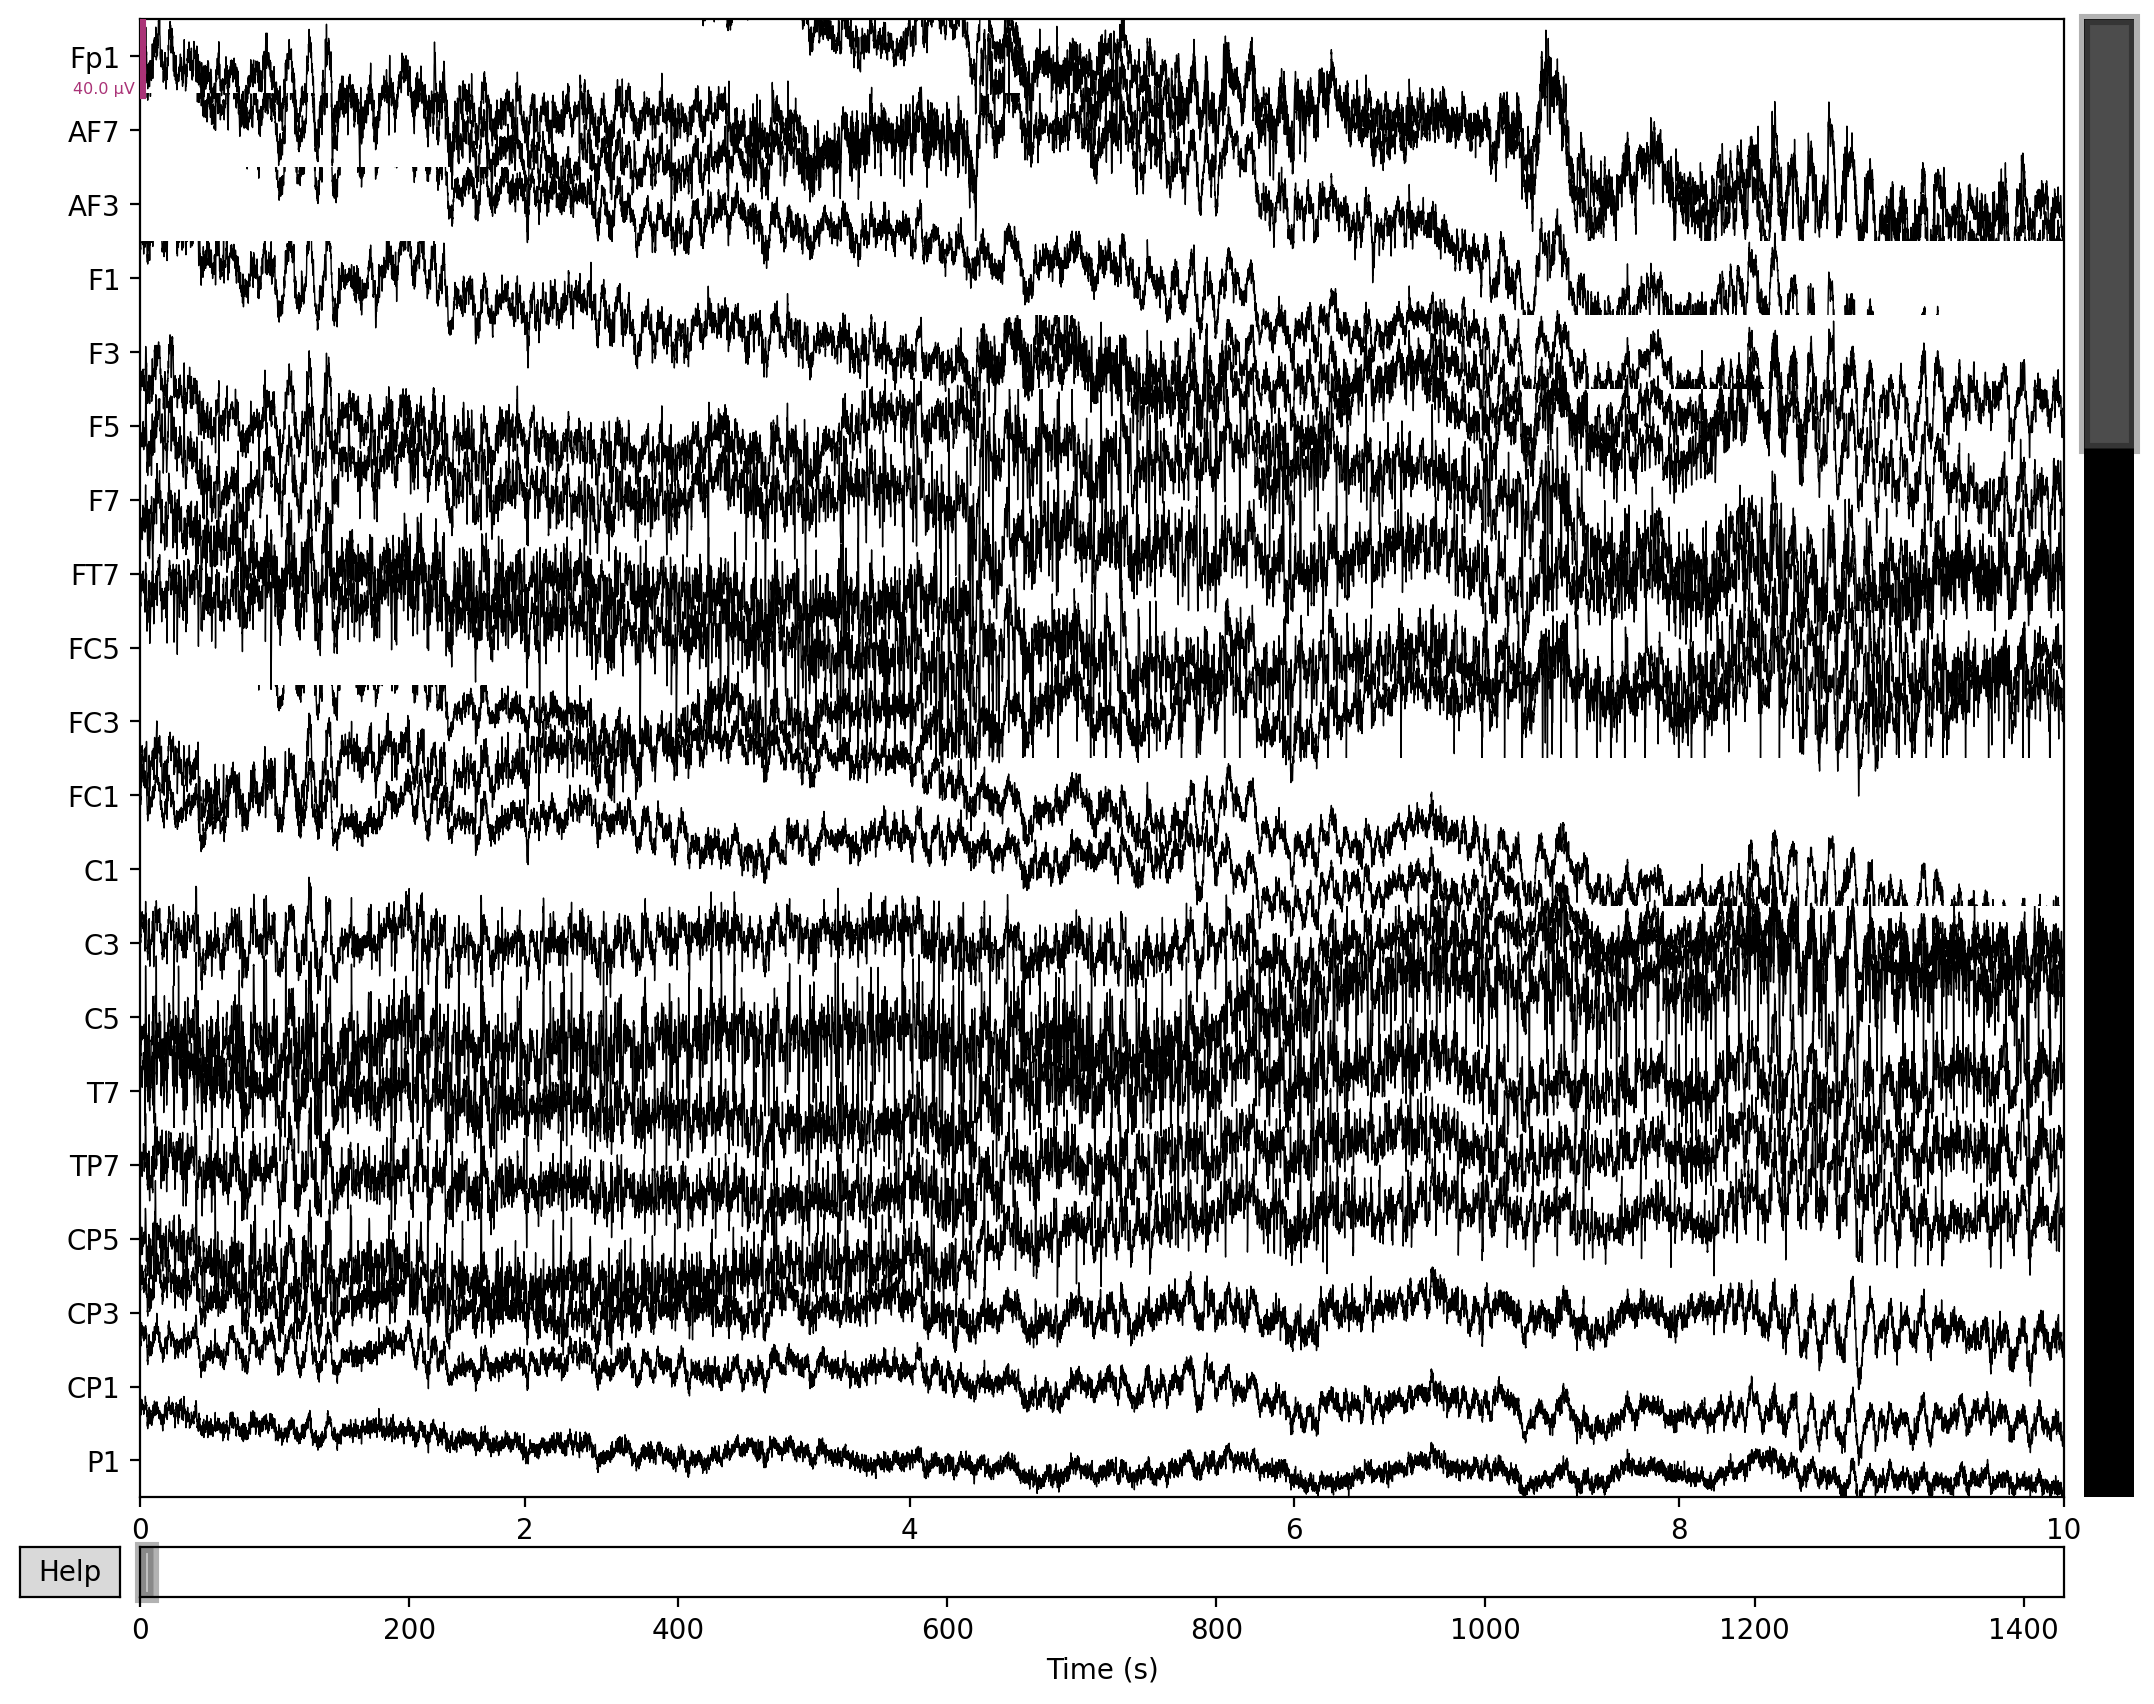

2025-05-09 01:59:28.666 Python[92326:11044488] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-09 01:59:28.666 Python[92326:11044488] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Channels marked as bad:
none


In [9]:
"""OZNACZENIE I INTERPOLACJA ZŁYCH KANAŁÓW"""
raw_original.info["bads"] = ["T7","TP7","POz","CP1","AFz","C3"]
raw_original.interpolate_bads(reset_bads=True)
raw_original.plot() 


In [15]:
"""USTAWIENIE REFERENCJI"""
raw_original.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [17]:
"""USTAWIENIE ADNOTACJI DLA SEGMENTÓW Z ARTEFAKTEM RUCHOWYM"""
onset_bad_segments = [410.0,406.0,235.4,492.0,1346.0,965.0] # początki artefaktów
duration_bad_segments = [1.5,1.5,3.2,14.0,22.0,20.0] # czasy trwania artefaktów 
description_bad_segments = [
    "BAD_short_muscle_2","BAD_short_muscle","BAD_muscle_mix_brain_artifact","BAD_Oz_movement_artifact","BAD_movement_POz_artifact","BAD_movement_artifact"]
my_annotations = mne.Annotations(onset=onset_bad_segments,duration=duration_bad_segments,description=description_bad_segments)
raw_original.set_annotations(my_annotations)

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

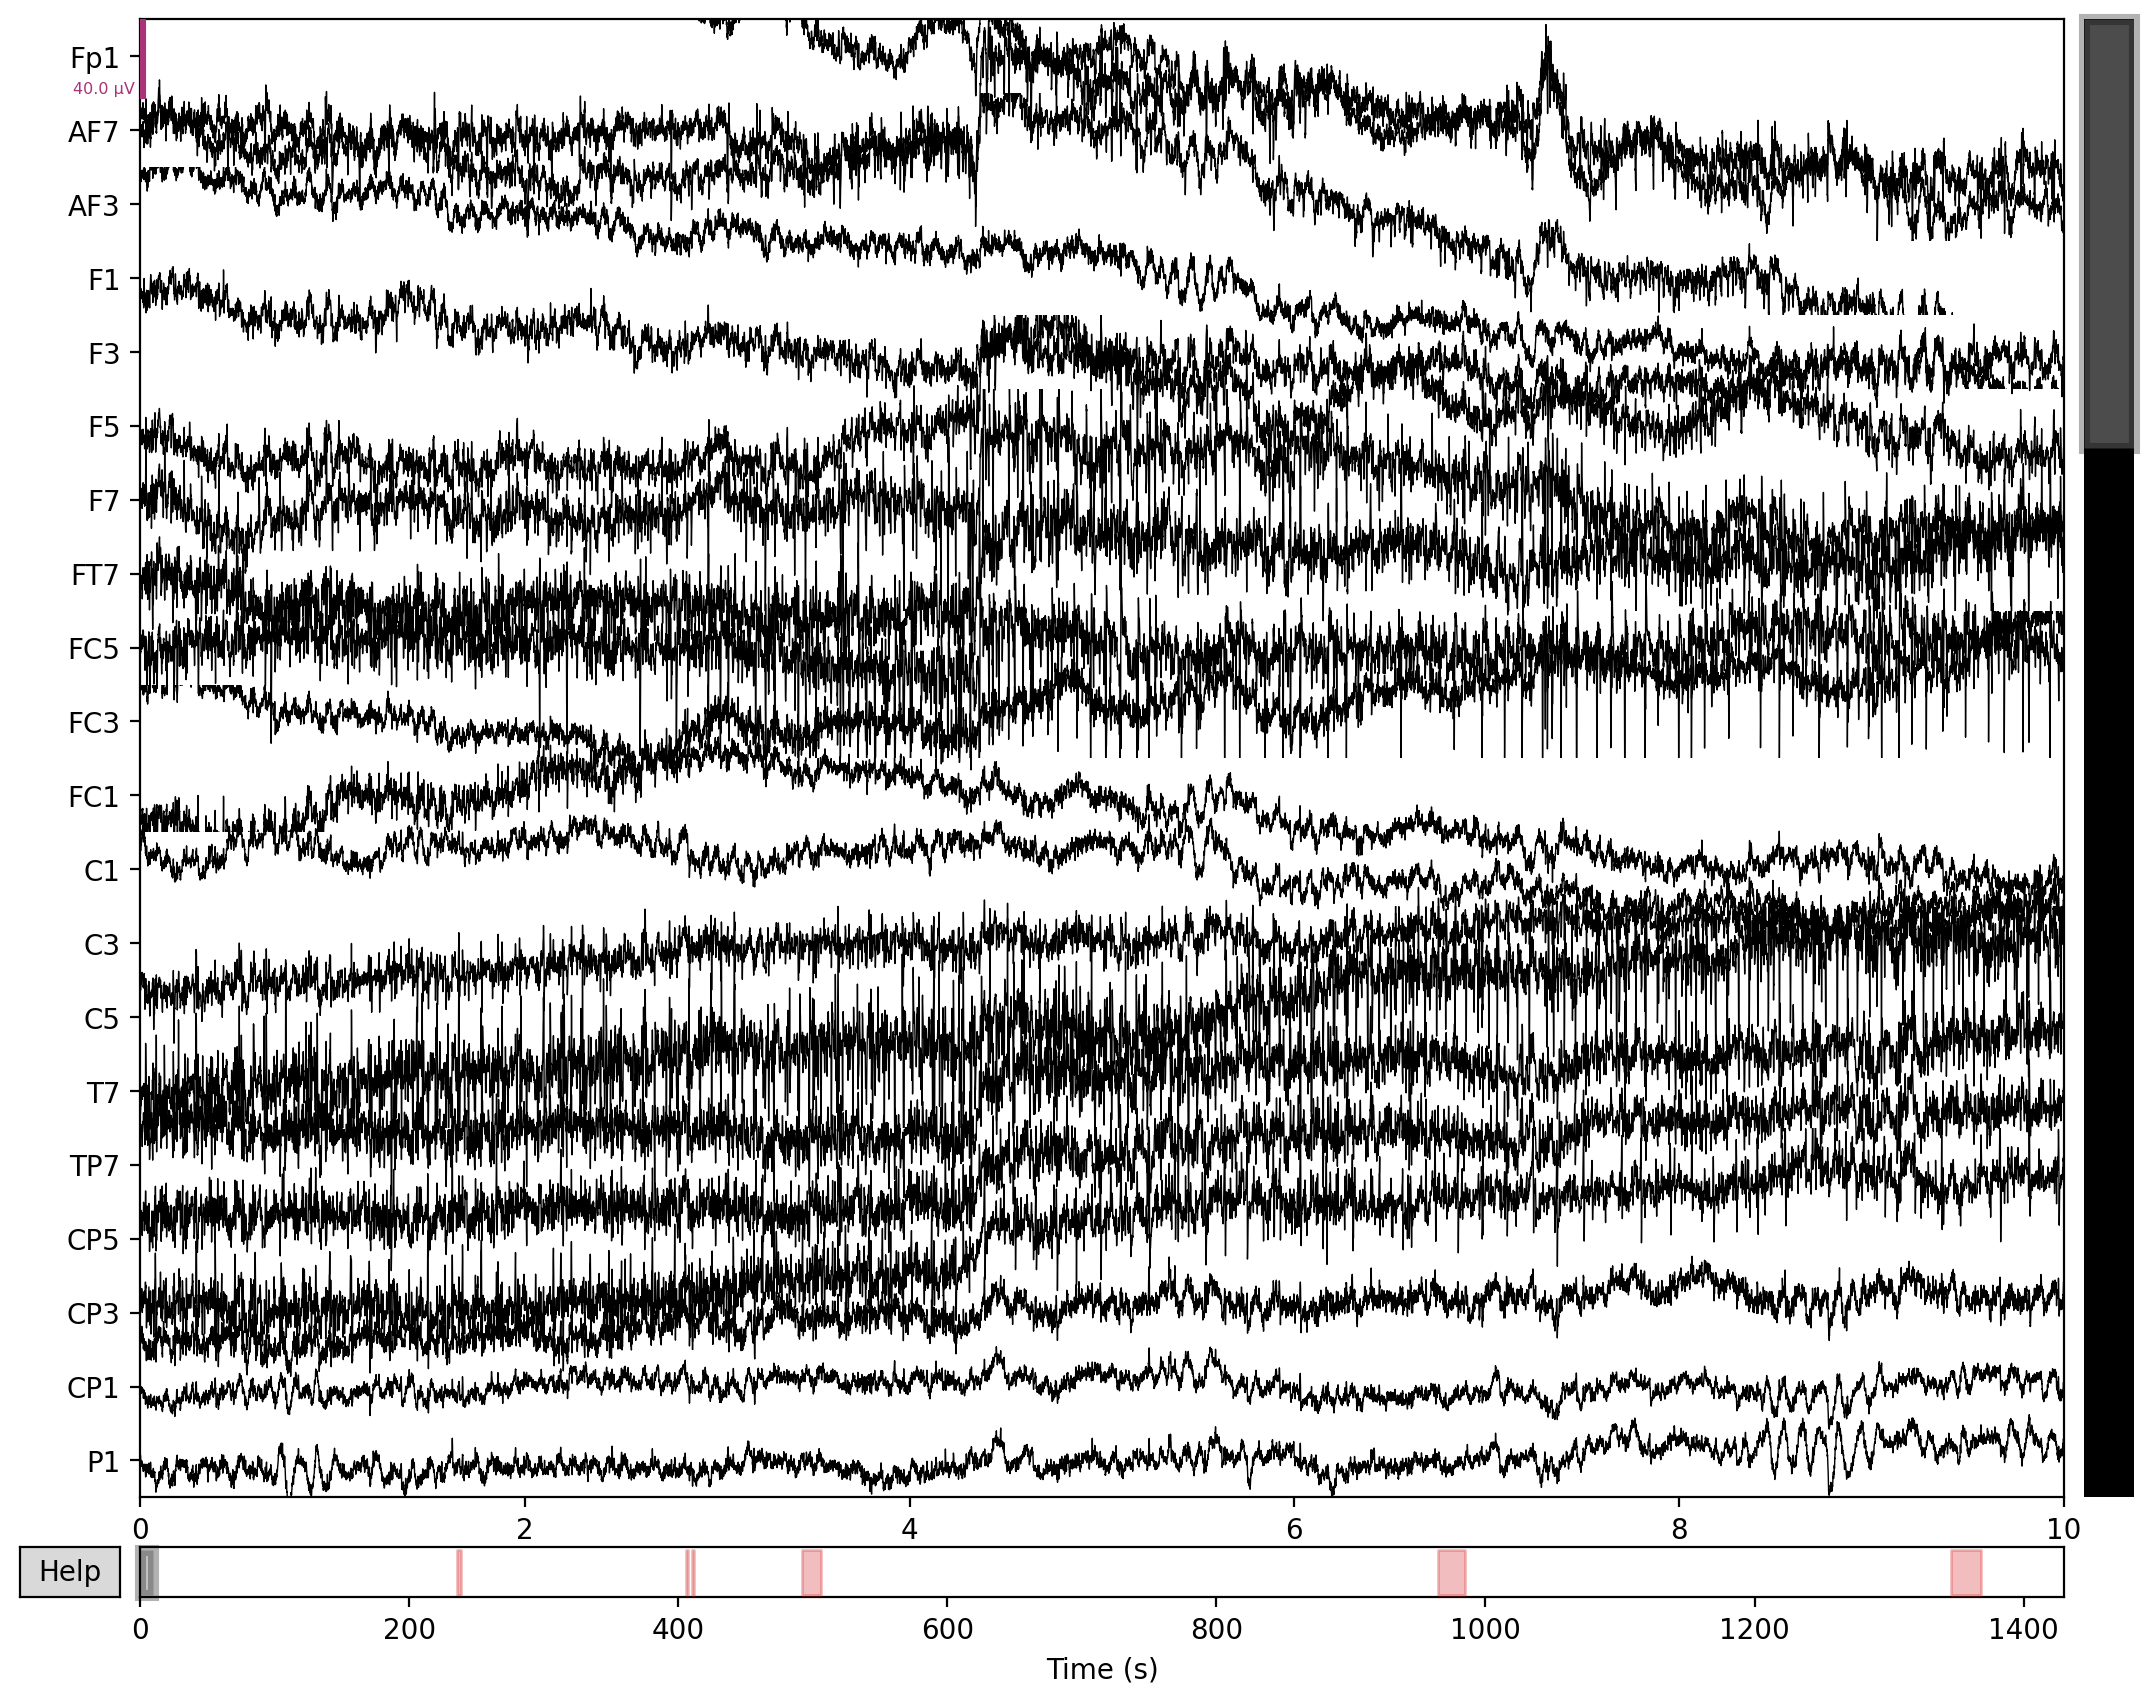

In [18]:
raw_original.plot()

In [19]:
"""TEST AMPLITUD"""

raw_original_amp_test = raw_original.copy()
ann_amp, _ = mne.preprocessing.annotate_amplitude(
    raw_original_amp_test,
    peak={'eeg': 100e-6, 'eog': 200e-6},  
    flat=None,
    bad_percent=5
)
raw_original_amp_test.set_annotations(raw_original_amp_test.annotations + ann_amp)

Finding segments below or above PTP threshold.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

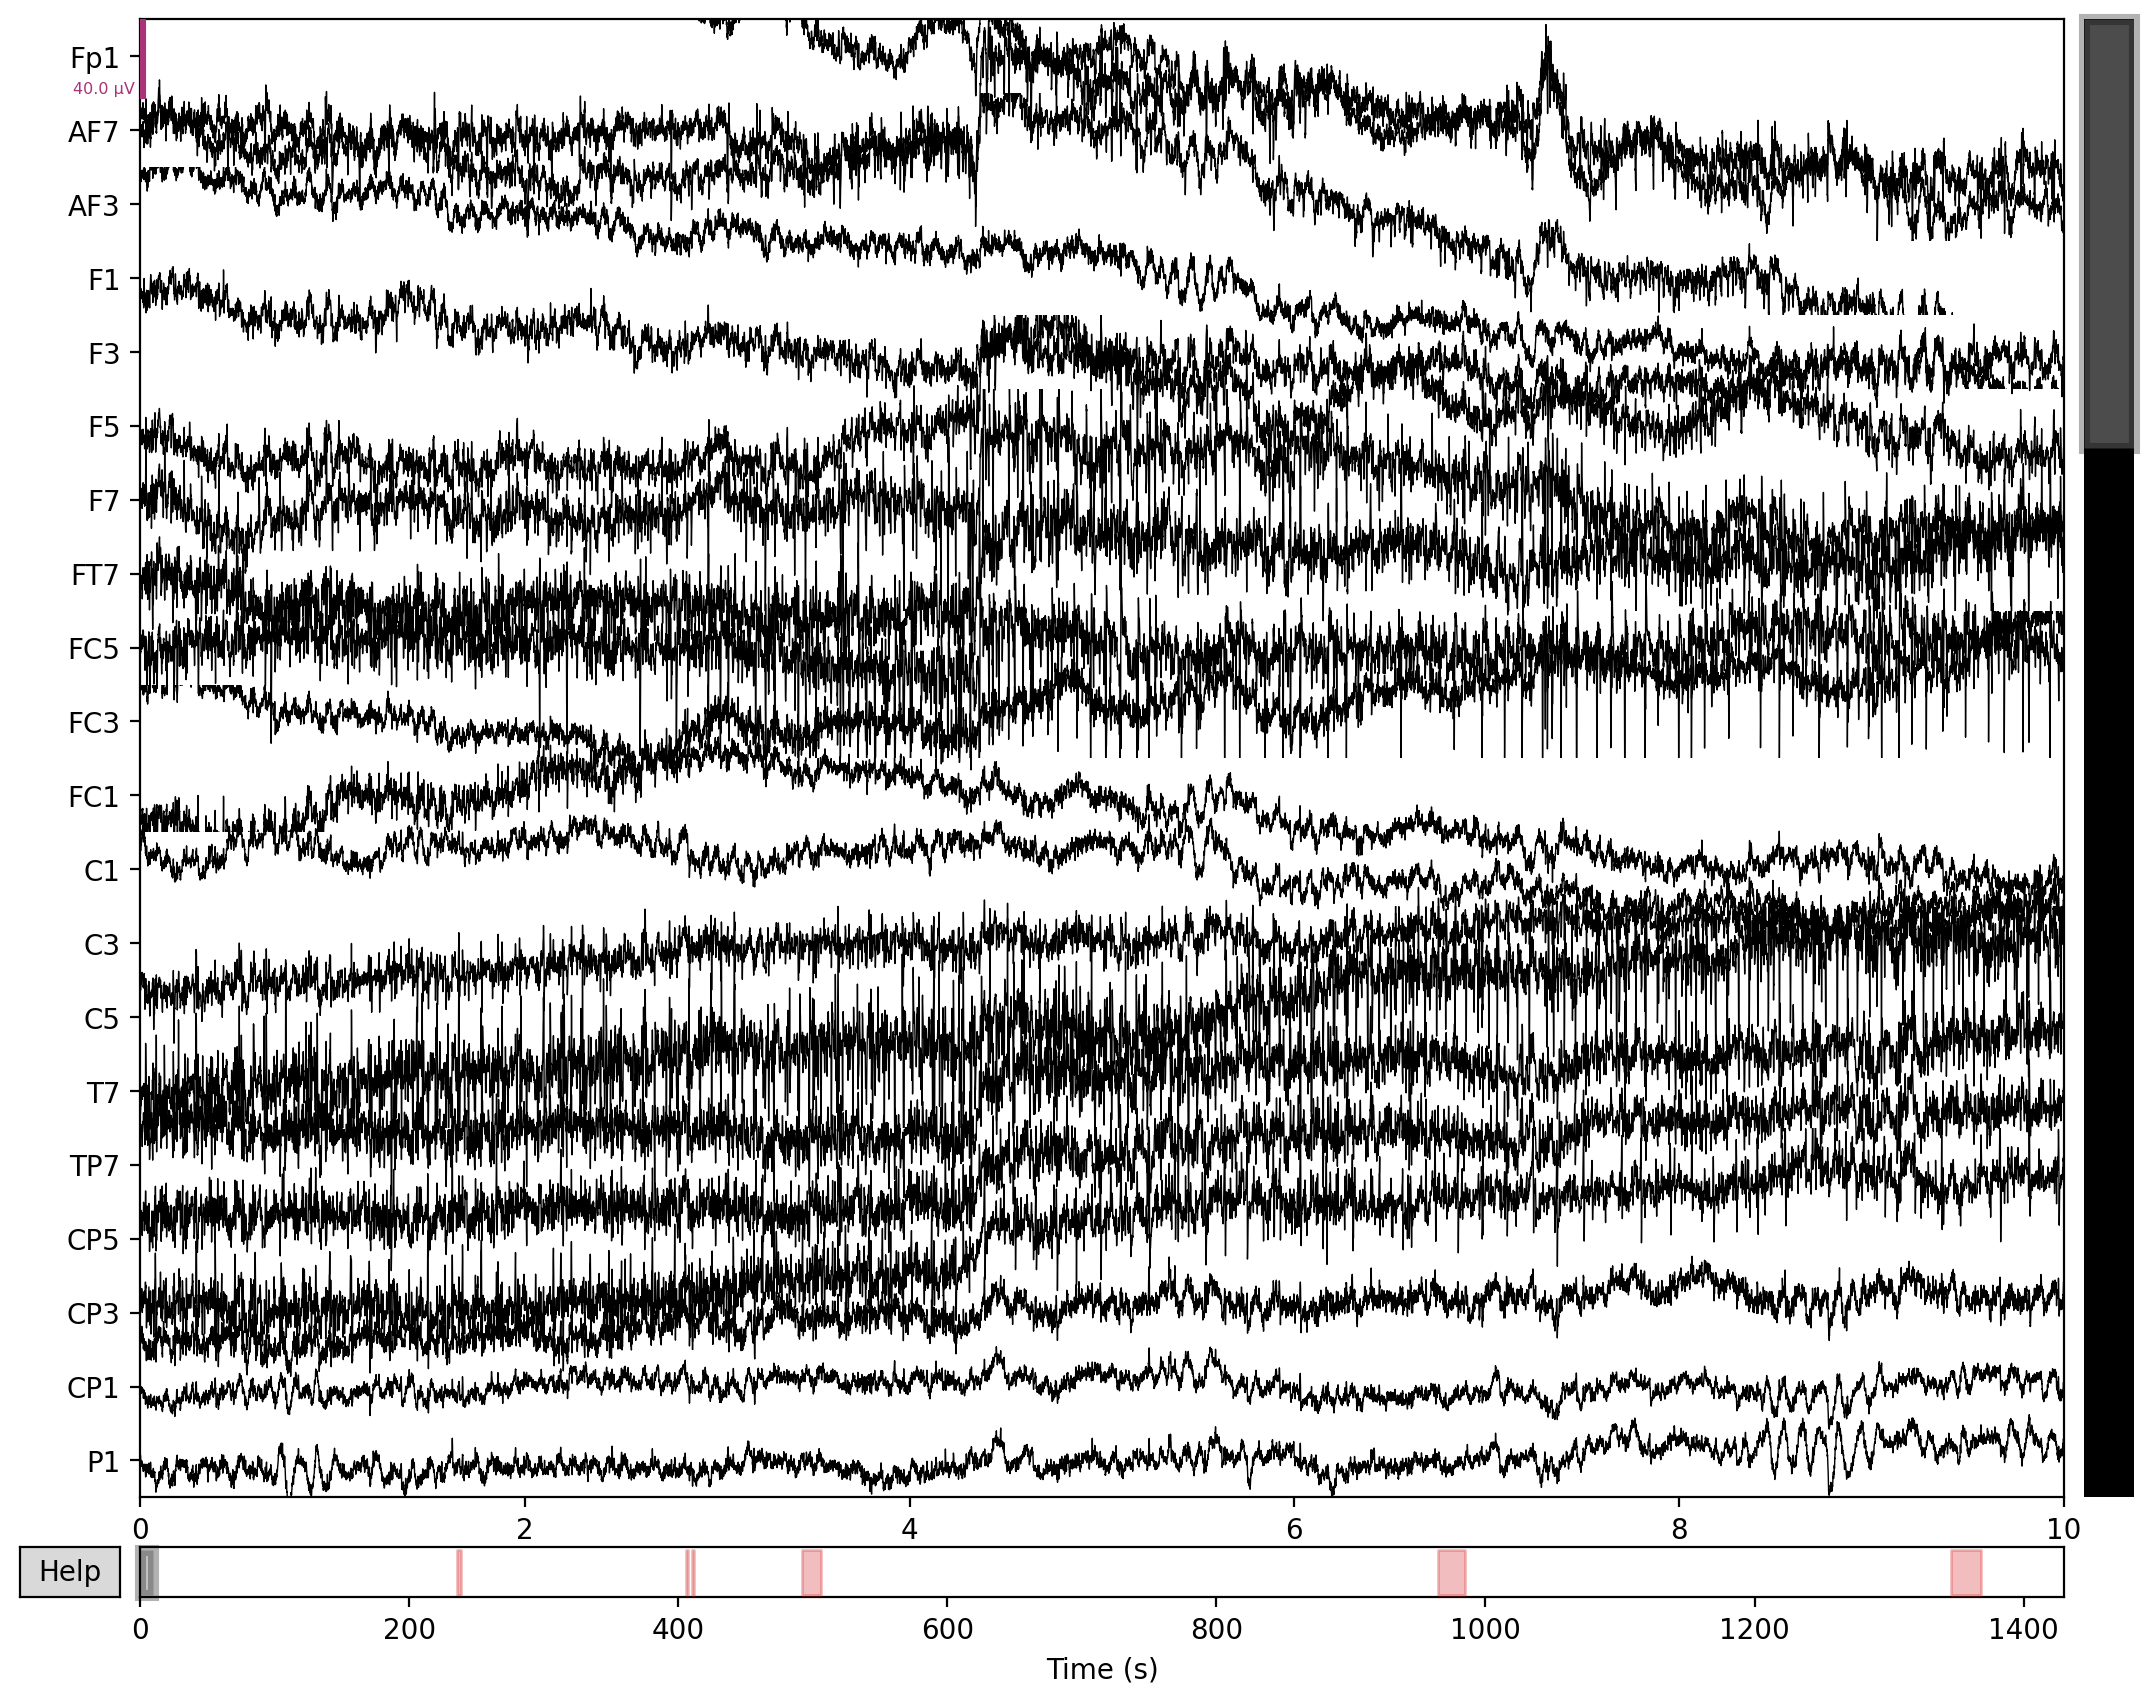

Channels marked as bad:
none


In [21]:
raw_original_amp_test.plot()

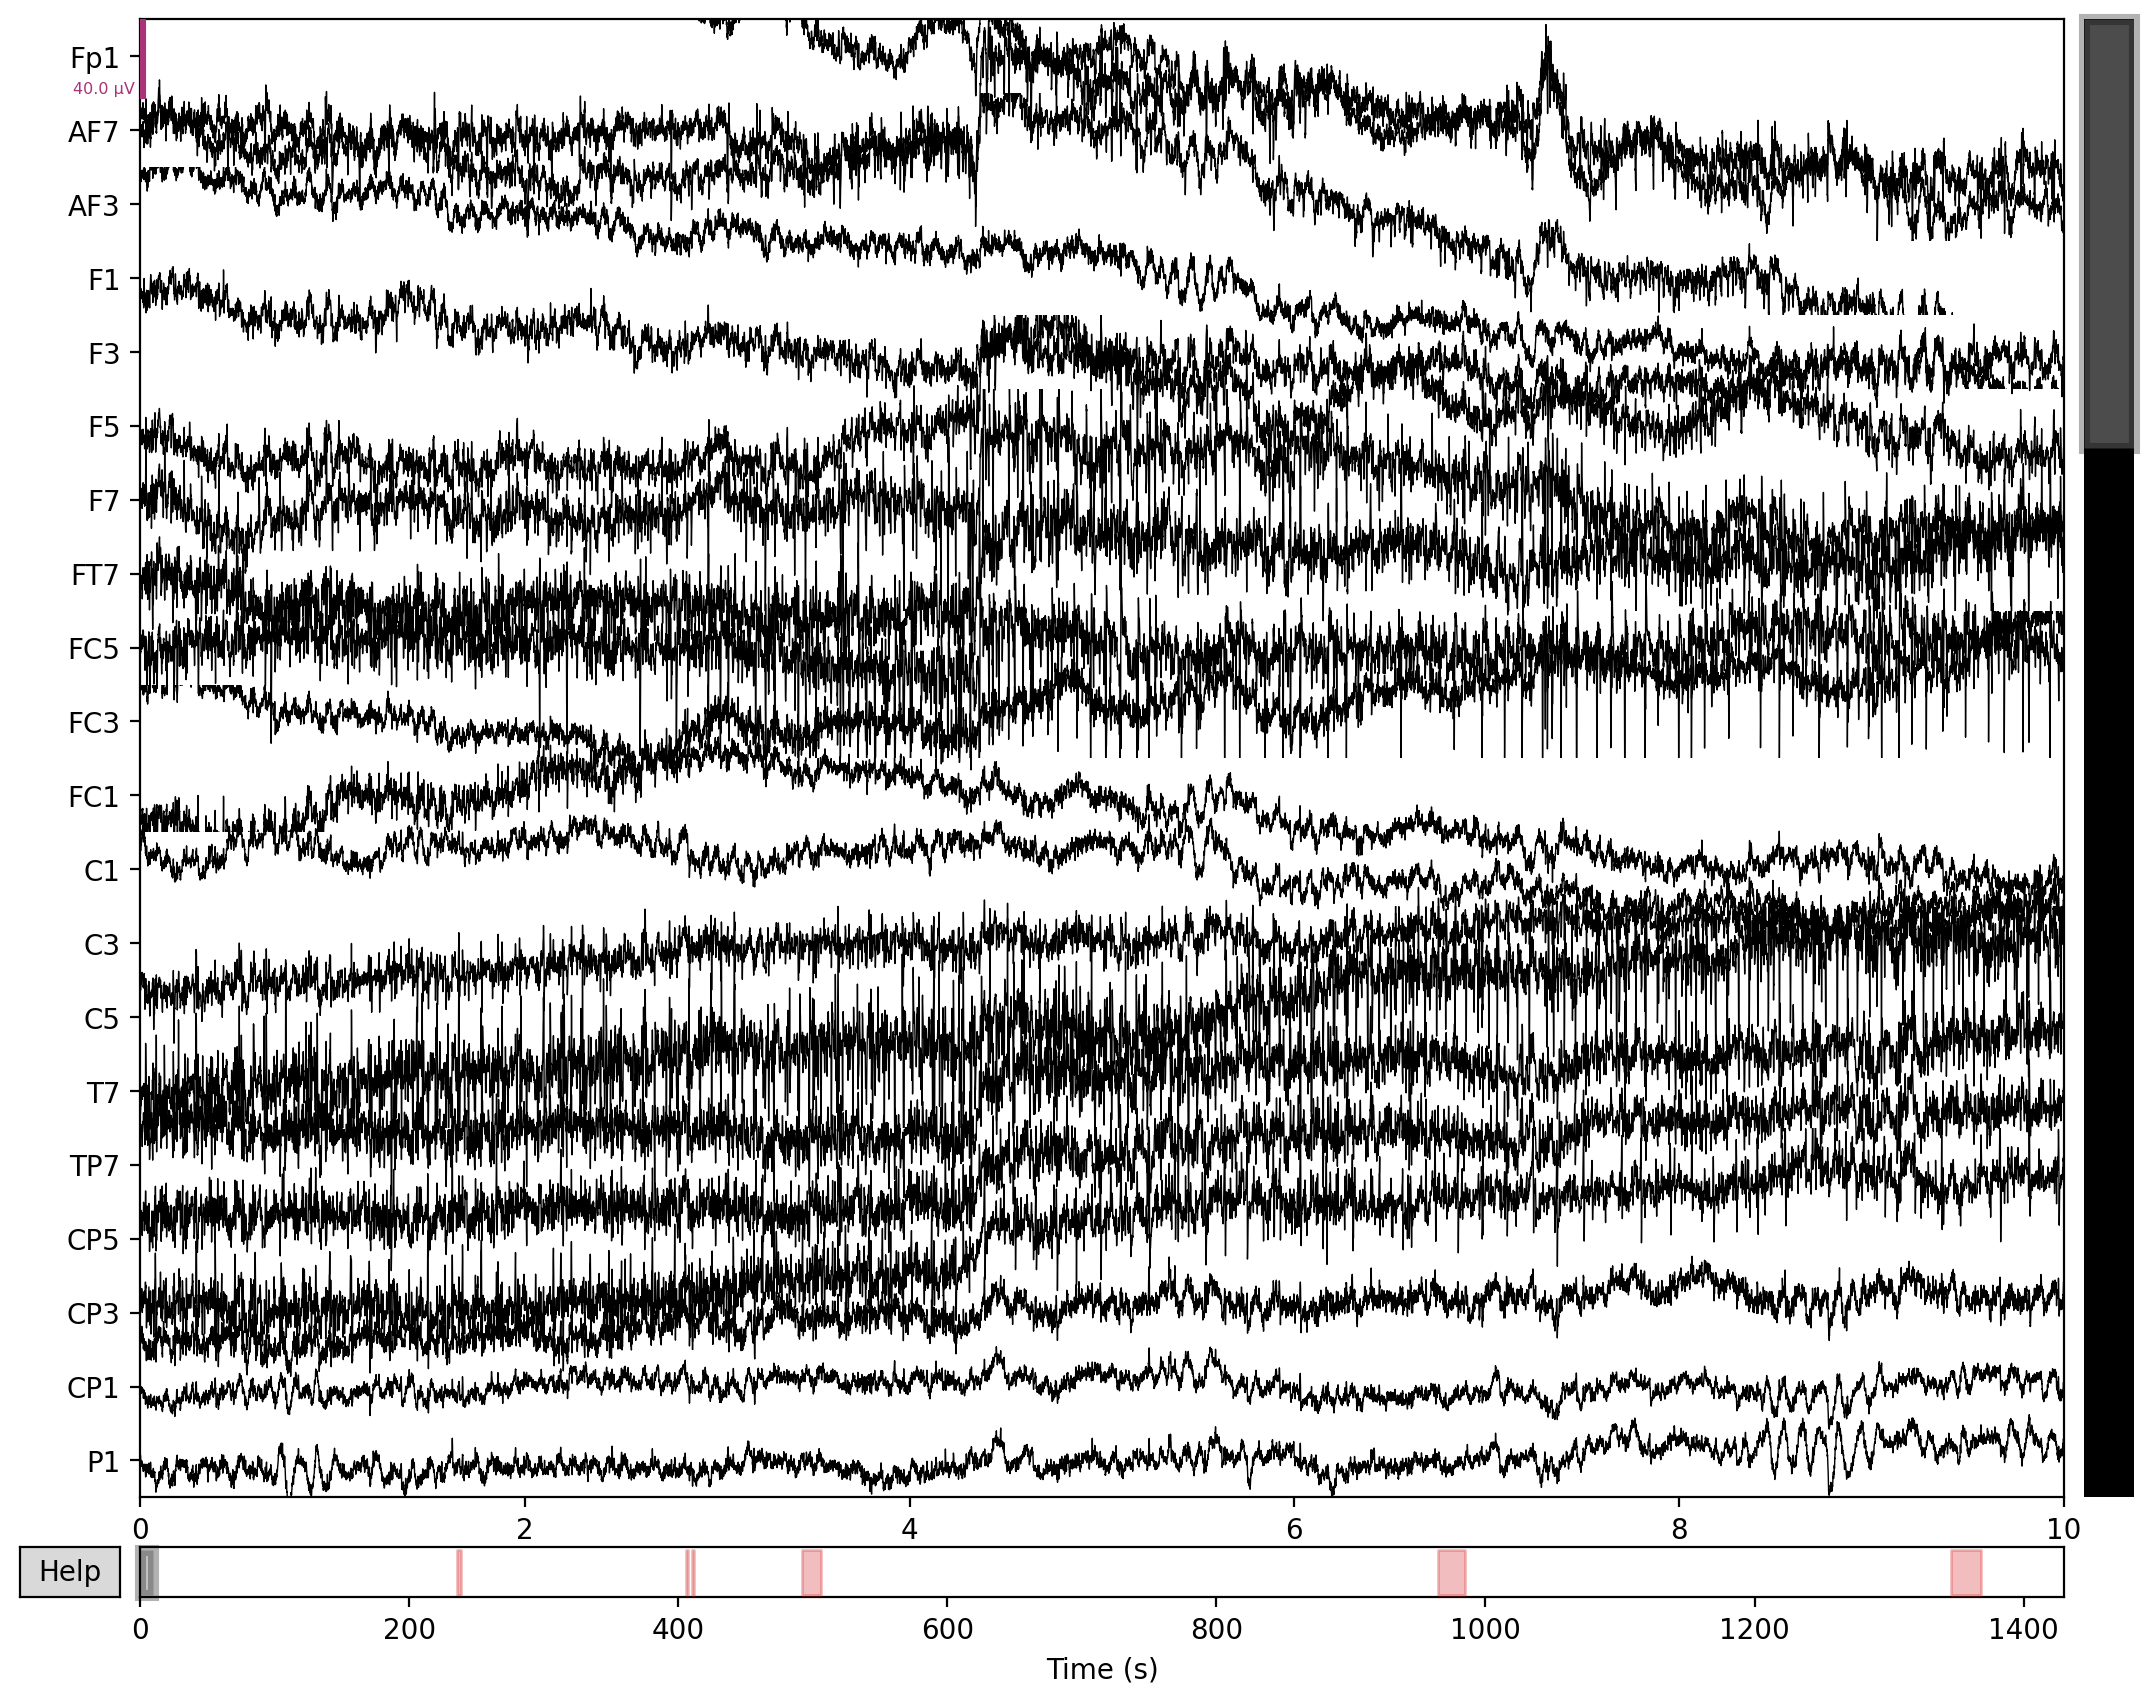

In [25]:
raw_original.plot()

Setting 127386 of 2928640 (4.35%) samples to NaN, retaining 2801254 (95.65%) samples.
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


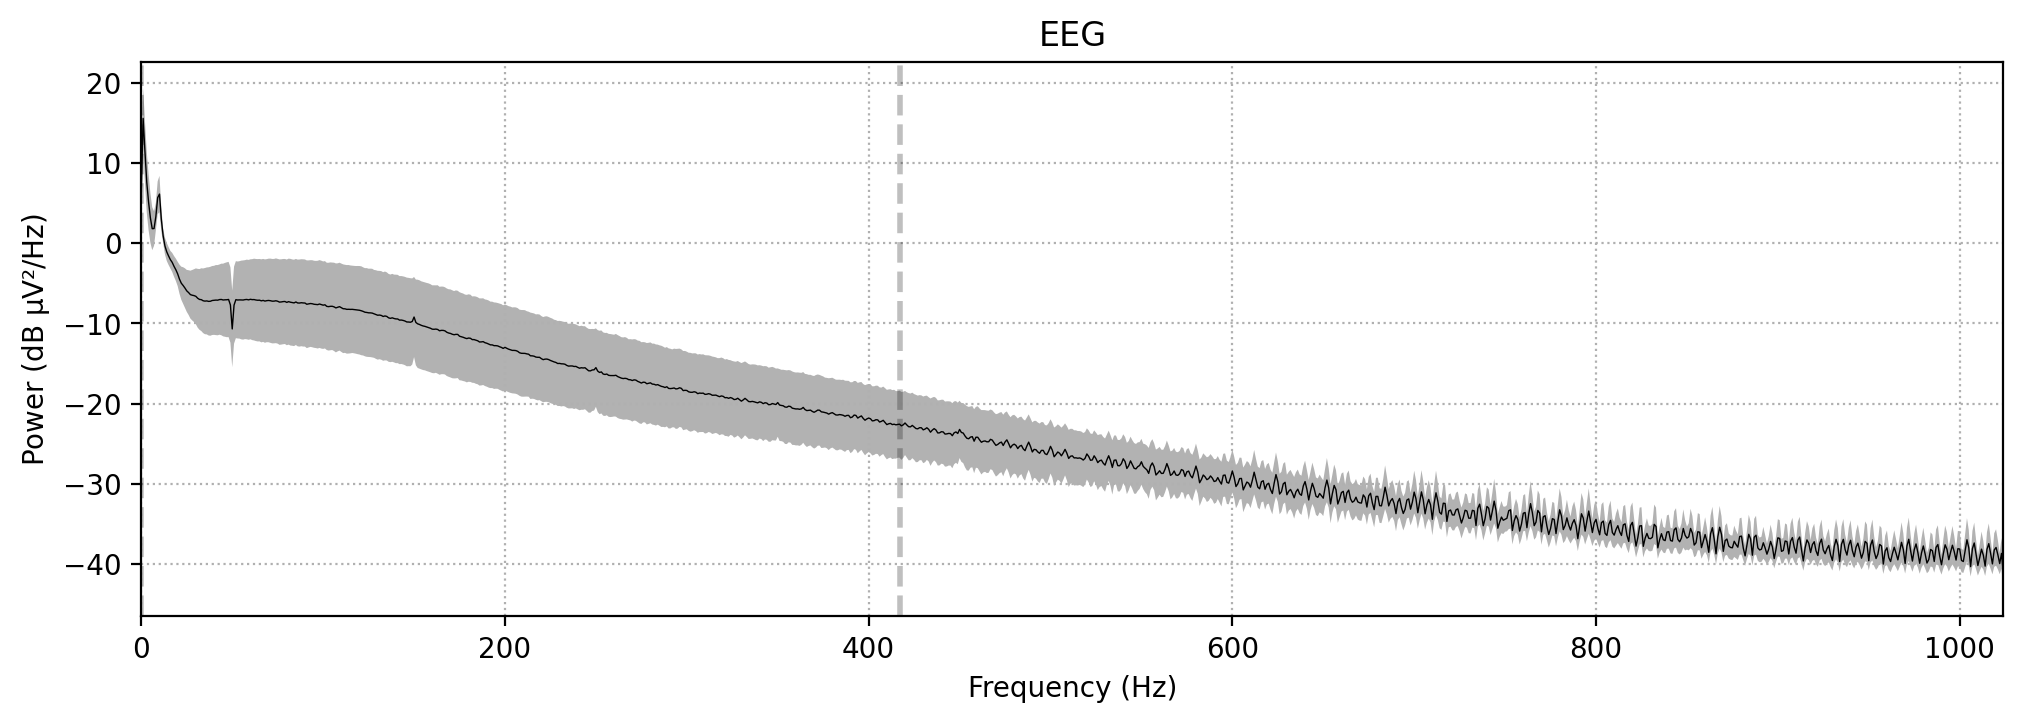

In [28]:
spectrum = raw_original.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

In [31]:
filt_test = raw_original.copy()
filt_test.filter(l_freq=1.0,h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

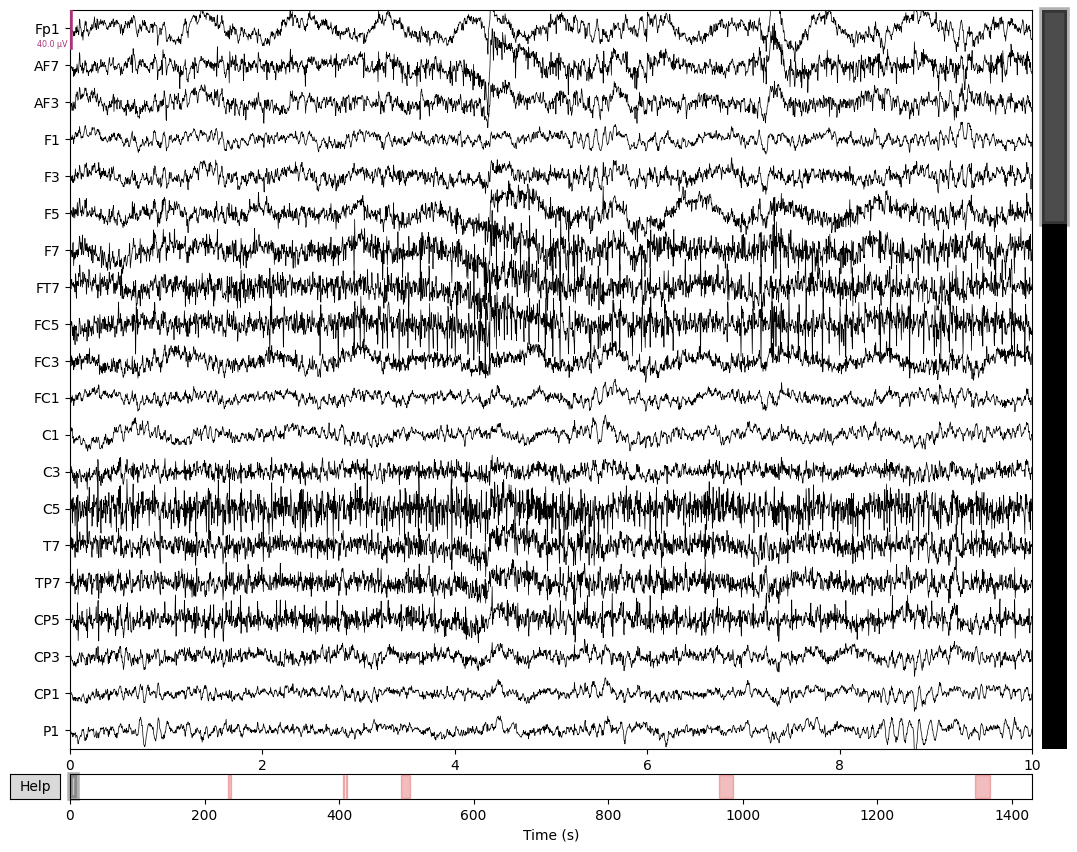

Channels marked as bad:
none
Channels marked as bad:
none


In [33]:
filt_test.plot()

In [1]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_for_ica_fitting, ch_name = "EXG3", tmin=-0.5, tmax=0.5)
eog_epochs = create_eog_epochs(raw_for_ica_fitting,ch_name=ch_eog)
eog_indices,eog_scores = ica.find_bads_eog(eog_epochs,ch_name=ch_eog)
eog_indices,eog_scores = ica.find_bads_eog(eog_epochs,ch_name="EXG3")

NameError: name 'create_ecg_epochs' is not defined

In [2]:
eog_indices_2, eog_scores_2 = ica.find_bads_eog(eog_epochs, measure="correlation",threshold=0.6)
print(eog_indices_2)

NameError: name 'ica' is not defined